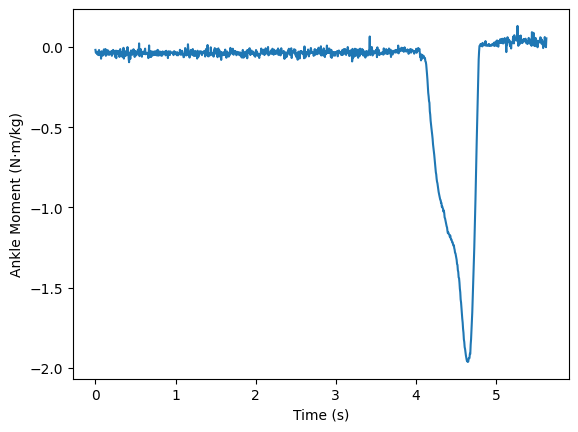

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

sto_file = "inverse_dynamics.sto"
mass = 64.5  # kg

# find endheader
with open(sto_file, 'r') as f:
    for i, line in enumerate(f):
        if 'endheader' in line.lower():
            header_line = i
            break

# read .sto data
data = pd.read_csv(
    sto_file,
    sep=r'\s+',
    skiprows=header_line + 1
)

# normalize time to start at 0
data['time'] = data['time'] - data['time'].iloc[0]

# normalize moments and forces by mass
for col in data.columns:
    if col.endswith('_moment') or col.endswith('_force'):
        data[col] = data[col] / mass

# save new file
data.to_csv('id_output_normalized_mass.sto', index=False)

plt.plot(data['time'], data['ankle_angle_l_moment'])
plt.xlabel('Time (s)')
plt.ylabel('Ankle Moment (N·m/kg)')
plt.show()



Estimated sampling frequency from file = 1000.00 Hz

HEEL STRIKE EVENTS
Time = 4.1340 s 	 Frame = 4135

TOE OFF EVENTS
Time = 4.8760 s 	 Frame = 4877

Saved event table as gait_events_HS_TO.csv


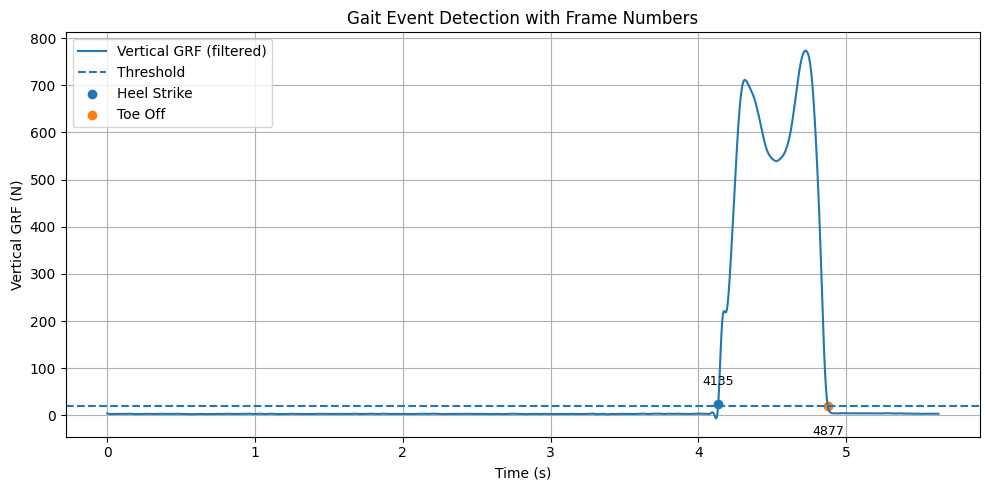

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# ==============================
# USER INPUTS
# ==============================
grf_file = 'stw1.mot'    # your force plate file
fs_assumed = 1000        # only used if time column missing
cutoff = 20              # Butterworth cutoff frequency (Hz)
threshold = 20           # force threshold (N)
min_width = 15           # minimum width in samples

# ==============================
# READ OpenSim .mot/.sto FILE
# ==============================
with open(grf_file, 'r') as f:
    for i, line in enumerate(f):
        if 'endheader' in line.lower():
            header_line = i
            break

data = pd.read_csv(
    grf_file,
    sep=r'\s+',
    skiprows=header_line + 1
)

time = data['time'].values
vy_raw = data['ground_force_2_vy'].values   # change if your label differs

# ==============================
# TRUE SAMPLING FREQUENCY
# ==============================
dt = np.mean(np.diff(time))
fs_estimated = 1 / dt
print(f"Estimated sampling frequency from file = {fs_estimated:.2f} Hz")

fs = fs_estimated

# ==============================
# FILTER SIGNAL
# ==============================
b, a = butter(
    N=4,
    Wn=cutoff / (fs / 2),
    btype='low'
)

vy_filt = filtfilt(b, a, vy_raw)

# ==============================
# GAIT EVENT DETECTION
# ==============================
above = vy_filt > threshold

HS_idx = []
TO_idx = []

i = 0
while i < len(above) - min_width:

    # Heel Strike: below -> above
    if not above[i] and all(above[i+1:i+1+min_width]):
        HS_idx.append(i + 1)
        i += min_width
        continue

    # Toe Off: above -> below
    if above[i] and all(~above[i+1:i+1+min_width]):
        TO_idx.append(i + 1)
        i += min_width
        continue

    i += 1

# ==============================
# CONVERT TO TIMES AND FRAMES
# ==============================
HS_times = time[HS_idx]
TO_times = time[TO_idx]

# frame = index + 1
HS_frames = np.array(HS_idx) + 1
TO_frames = np.array(TO_idx) + 1

# ==============================
# PRINT RESULTS
# ==============================
print("\n==============================")
print("HEEL STRIKE EVENTS")
print("==============================")
for t, fr in zip(HS_times, HS_frames):
    print(f"Time = {t:.4f} s \t Frame = {fr}")

print("\n==============================")
print("TOE OFF EVENTS")
print("==============================")
for t, fr in zip(TO_times, TO_frames):
    print(f"Time = {t:.4f} s \t Frame = {fr}")

# ==============================
# SAVE TO CSV
# ==============================
events = pd.DataFrame({
    "HS_time_s": HS_times,
    "HS_frame": HS_frames,
    "TO_time_s": TO_times,
    "TO_frame": TO_frames
})

events.to_csv("gait_events_HS_TO.csv", index=False)
print("\nSaved event table as gait_events_HS_TO.csv")

# ==============================
# PLOT WITH FRAME NUMBERS
# ==============================
plt.figure(figsize=(10, 5))

plt.plot(time, vy_filt, label='Vertical GRF (filtered)')
plt.axhline(threshold, linestyle='--', label='Threshold')

# event markers
plt.scatter(HS_times, vy_filt[HS_idx], label='Heel Strike')
plt.scatter(TO_times, vy_filt[TO_idx], label='Toe Off')

# ==============================
# WRITE FRAME NUMBERS ON PLOT
# ==============================
for t, fr, idx in zip(HS_times, HS_frames, HS_idx):
    plt.text(t, vy_filt[idx] + 40, f'{fr}', ha='center', fontsize=9)

for t, fr, idx in zip(TO_times, TO_frames, TO_idx):
    plt.text(t, vy_filt[idx] - 60, f'{fr}', ha='center', fontsize=9)

plt.xlabel('Time (s)')
plt.ylabel('Vertical GRF (N)')
plt.title('Gait Event Detection with Frame Numbers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Estimated GRF sampling frequency = 1000.00 Hz

HEEL STRIKE EVENTS
Time = 4.1340 s 	 GRF frame = 4135 	 TRC frame = 827

TOE OFF EVENTS
Time = 4.8760 s 	 GRF frame = 4877 	 TRC frame = 976

Saved: gait_events_HS_TO_frames.csv


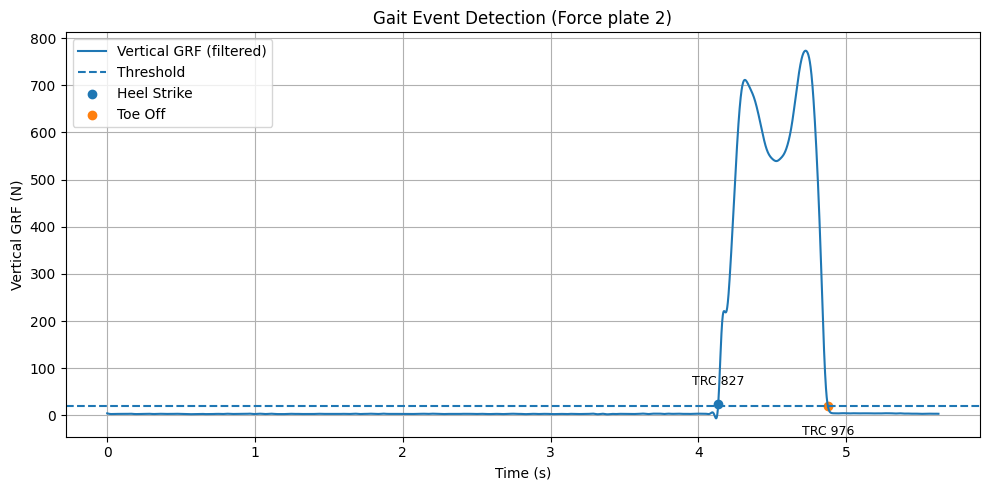

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# ==============================
# USER INPUTS
# ==============================
grf_file = 'stw1.mot'        # GRF file
trc_fs = 200                 # TRC sampling frequency (Hz)
cutoff = 20                  # Butterworth cutoff (Hz)
threshold = 20               # vertical GRF threshold (N)
min_width = 15               # minimum width in samples

# ==============================
# READ OpenSim .mot/.sto FILE
# ==============================
with open(grf_file, 'r') as f:
    for i, line in enumerate(f):
        if 'endheader' in line.lower():
            header_line = i
            break

data = pd.read_csv(
    grf_file,
    sep=r'\s+',
    skiprows=header_line + 1
)

time = data['time'].values
vy_raw = data['ground_force_2_vy'].values   # change if column different

# ==============================
# TRUE GRF SAMPLING FREQUENCY
# ==============================
dt = np.mean(np.diff(time))
fs_grf = 1 / dt
print(f"\nEstimated GRF sampling frequency = {fs_grf:.2f} Hz")

# ==============================
# FILTER GRF
# ==============================
b, a = butter(
    N=4,
    Wn=cutoff / (fs_grf / 2),
    btype='low'
)

vy_filt = filtfilt(b, a, vy_raw)

# ==============================
# EVENT DETECTION (HS & TO)
# ==============================
above = vy_filt > threshold

HS_idx = []
TO_idx = []

i = 0
while i < len(above) - min_width:

    # Heel Strike: below -> above
    if not above[i] and all(above[i+1:i+1+min_width]):
        HS_idx.append(i + 1)
        i += min_width
        continue

    # Toe Off: above -> below
    if above[i] and all(~above[i+1:i+1+min_width]):
        TO_idx.append(i + 1)
        i += min_width
        continue

    i += 1

# ==============================
# EVENT TIMES
# ==============================
HS_times = time[HS_idx]
TO_times = time[TO_idx]

# ==============================
# GRF FRAMES (1000 Hz approx)
# ==============================
HS_frames_grf = np.array(HS_idx) + 1
TO_frames_grf = np.array(TO_idx) + 1

# ==============================
# TRC FRAMES (200 Hz EXACT)
# ==============================
HS_frames_trc = (HS_times * trc_fs).astype(int) + 1
TO_frames_trc = (TO_times * trc_fs).astype(int) + 1

# ==============================
# PRINT EVENTS
# ==============================
print("\n==============================")
print("HEEL STRIKE EVENTS")
print("==============================")
for t, f1, f2 in zip(HS_times, HS_frames_grf, HS_frames_trc):
    print(f"Time = {t:.4f} s \t GRF frame = {f1} \t TRC frame = {f2}")

print("\n==============================")
print("TOE OFF EVENTS")
print("==============================")
for t, f1, f2 in zip(TO_times, TO_frames_grf, TO_frames_trc):
    print(f"Time = {t:.4f} s \t GRF frame = {f1} \t TRC frame = {f2}")

# ==============================
# SAVE EVENTS TO CSV
# ==============================
events = pd.DataFrame({
    "HS_time_s": HS_times,
    "HS_frame_GRF": HS_frames_grf,
    "HS_frame_TRC": HS_frames_trc,
    "TO_time_s": TO_times,
    "TO_frame_GRF": TO_frames_grf,
    "TO_frame_TRC": TO_frames_trc
})

events.to_csv("gait_events_HS_TO_frames.csv", index=False)
print("\nSaved: gait_events_HS_TO_frames.csv")

# ==============================
# PLOT WITH FRAME NUMBERS ON GRAPH
# ==============================
plt.figure(figsize=(10, 5))

plt.plot(time, vy_filt, label='Vertical GRF (filtered)')
plt.axhline(threshold, linestyle='--', label='Threshold')

plt.scatter(HS_times, vy_filt[HS_idx], label='Heel Strike')
plt.scatter(TO_times, vy_filt[TO_idx], label='Toe Off')

# ---- annotate TRC frames directly on graph ----
for t, fr, idx in zip(HS_times, HS_frames_trc, HS_idx):
    plt.text(t, vy_filt[idx] + 40, f'TRC {fr}', ha='center', fontsize=9)

for t, fr, idx in zip(TO_times, TO_frames_trc, TO_idx):
    plt.text(t, vy_filt[idx] - 60, f'TRC {fr}', ha='center', fontsize=9)

plt.xlabel('Time (s)')
plt.ylabel('Vertical GRF (N)')
plt.title('Gait Event Detection (Force plate 2)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Estimated GRF sampling frequency = 1000.00 Hz

HEEL STRIKE EVENTS
Time = 4.7400 s 	 GRF frame = 4741 	 TRC frame = 949

TOE OFF EVENTS
Time = 5.4430 s 	 GRF frame = 5444 	 TRC frame = 1089

Saved: gait_events_HS_TO_frames.csv


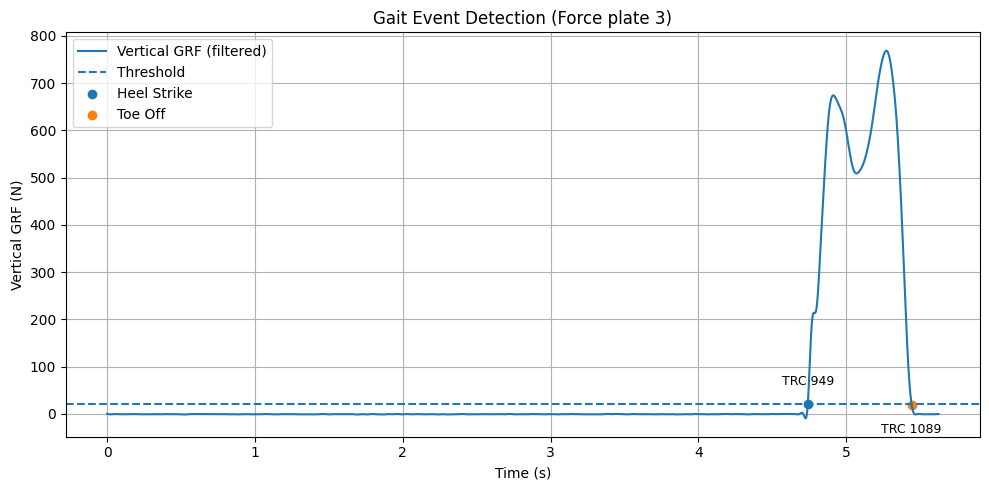

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# ==============================
# USER INPUTS
# ==============================
grf_file = 'stw1.mot'        # GRF file
trc_fs = 200                 # TRC sampling frequency (Hz)
cutoff = 20                  # Butterworth cutoff (Hz)
threshold = 20               # vertical GRF threshold (N)
min_width = 15               # minimum width in samples

# ==============================
# READ OpenSim .mot/.sto FILE
# ==============================
with open(grf_file, 'r') as f:
    for i, line in enumerate(f):
        if 'endheader' in line.lower():
            header_line = i
            break

data = pd.read_csv(
    grf_file,
    sep=r'\s+',
    skiprows=header_line + 1
)

time = data['time'].values
vy_raw = data['ground_force_3_vy'].values   # change if column different

# ==============================
# TRUE GRF SAMPLING FREQUENCY
# ==============================
dt = np.mean(np.diff(time))
fs_grf = 1 / dt
print(f"\nEstimated GRF sampling frequency = {fs_grf:.2f} Hz")

# ==============================
# FILTER GRF
# ==============================
b, a = butter(
    N=4,
    Wn=cutoff / (fs_grf / 2),
    btype='low'
)

vy_filt = filtfilt(b, a, vy_raw)

# ==============================
# EVENT DETECTION (HS & TO)
# ==============================
above = vy_filt > threshold

HS_idx = []
TO_idx = []

i = 0
while i < len(above) - min_width:

    # Heel Strike: below -> above
    if not above[i] and all(above[i+1:i+1+min_width]):
        HS_idx.append(i + 1)
        i += min_width
        continue

    # Toe Off: above -> below
    if above[i] and all(~above[i+1:i+1+min_width]):
        TO_idx.append(i + 1)
        i += min_width
        continue

    i += 1

# ==============================
# EVENT TIMES
# ==============================
HS_times = time[HS_idx]
TO_times = time[TO_idx]

# ==============================
# GRF FRAMES (1000 Hz approx)
# ==============================
HS_frames_grf = np.array(HS_idx) + 1
TO_frames_grf = np.array(TO_idx) + 1

# ==============================
# TRC FRAMES (200 Hz EXACT)
# ==============================
HS_frames_trc = (HS_times * trc_fs).astype(int) + 1
TO_frames_trc = (TO_times * trc_fs).astype(int) + 1

# ==============================
# PRINT EVENTS
# ==============================
print("\n==============================")
print("HEEL STRIKE EVENTS")
print("==============================")
for t, f1, f2 in zip(HS_times, HS_frames_grf, HS_frames_trc):
    print(f"Time = {t:.4f} s \t GRF frame = {f1} \t TRC frame = {f2}")

print("\n==============================")
print("TOE OFF EVENTS")
print("==============================")
for t, f1, f2 in zip(TO_times, TO_frames_grf, TO_frames_trc):
    print(f"Time = {t:.4f} s \t GRF frame = {f1} \t TRC frame = {f2}")

# ==============================
# SAVE EVENTS TO CSV
# ==============================
events = pd.DataFrame({
    "HS_time_s": HS_times,
    "HS_frame_GRF": HS_frames_grf,
    "HS_frame_TRC": HS_frames_trc,
    "TO_time_s": TO_times,
    "TO_frame_GRF": TO_frames_grf,
    "TO_frame_TRC": TO_frames_trc
})

events.to_csv("gait_events_HS_TO_frames.csv", index=False)
print("\nSaved: gait_events_HS_TO_frames.csv")

# ==============================
# PLOT WITH FRAME NUMBERS ON GRAPH
# ==============================
plt.figure(figsize=(10, 5))

plt.plot(time, vy_filt, label='Vertical GRF (filtered)')
plt.axhline(threshold, linestyle='--', label='Threshold')

plt.scatter(HS_times, vy_filt[HS_idx], label='Heel Strike')
plt.scatter(TO_times, vy_filt[TO_idx], label='Toe Off')

# ---- annotate TRC frames directly on graph ----
for t, fr, idx in zip(HS_times, HS_frames_trc, HS_idx):
    plt.text(t, vy_filt[idx] + 40, f'TRC {fr}', ha='center', fontsize=9)

for t, fr, idx in zip(TO_times, TO_frames_trc, TO_idx):
    plt.text(t, vy_filt[idx] - 60, f'TRC {fr}', ha='center', fontsize=9)

plt.xlabel('Time (s)')
plt.ylabel('Vertical GRF (N)')
plt.title('Gait Event Detection (Force plate 3)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
